In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
! pip install split-folders --quiet

In [3]:
import splitfolders

In [ ]:
splitfolders.ratio("/content/drive/MyDrive/data/images", output="/content/drive/MyDrive/data/ouputim",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) 


Copying files: 3779 files [37:49,  1.93 files/s]

In [5]:
df_train = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/data/ouputim/train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    
)

Found 3107 files belonging to 2 classes.


In [6]:
len(df_train)

98

In [7]:
98*32

3136

In [8]:
classes = df_train.class_names
classes

['Female', 'Male']

In [9]:
for image, label in df_train.take(1):
  print(image.numpy())
  print(label.numpy())

[[[[248.25 248.25 249.25]
   [253.75 253.   251.75]
   [253.5  253.25 251.25]
   ...
   [253.5  253.   251.  ]
   [254.75 254.5  251.5 ]
   [240.75 239.75 234.5 ]]

  [[250.25 251.75 250.  ]
   [253.   253.75 249.5 ]
   [253.25 254.5  249.5 ]
   ...
   [251.75 252.75 247.5 ]
   [249.25 250.5  247.25]
   [191.   193.   182.25]]

  [[250.   252.   249.  ]
   [252.75 253.75 248.75]
   [253.5  254.5  249.5 ]
   ...
   [248.75 252.25 247.75]
   [225.25 225.25 220.75]
   [244.25 247.25 247.25]]

  ...

  [[240.25 107.   101.  ]
   [245.25  98.25 101.75]
   [248.75 100.   103.  ]
   ...
   [ 88.5  106.    79.25]
   [ 95.75 111.5   80.75]
   [ 97.25 109.75  80.75]]

  [[241.25 106.75 111.  ]
   [243.5   96.5  104.25]
   [248.    98.   104.  ]
   ...
   [102.75 112.75  82.75]
   [108.75 116.75  86.25]
   [115.5  120.5   87.  ]]

  [[233.5  124.75 128.25]
   [244.5  103.25 111.25]
   [242.75  94.5  106.75]
   ...
   [114.75 121.25  89.5 ]
   [120.5  123.25  93.  ]
   [123.   119.25  91.  ]]]


 

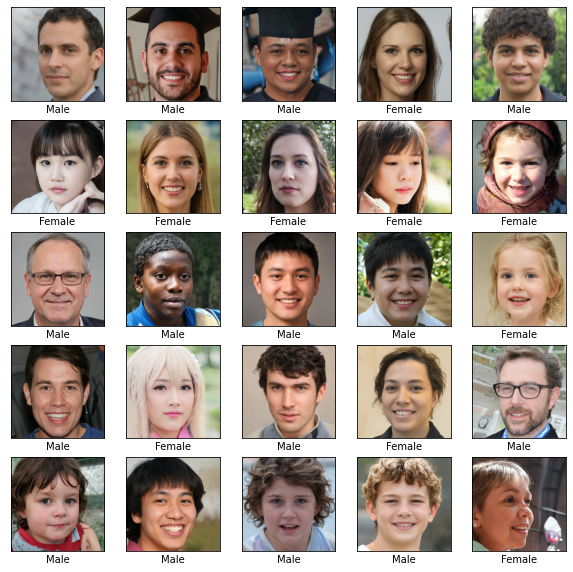

In [10]:
for image, label in df_train.take(1):
  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[i].numpy().astype('int'), cmap=plt.cm.binary)
    plt.xlabel(classes[label[i]])
  plt.show()

In [11]:
df_vali = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/data/ouputim/val',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
  
)

Found 387 files belonging to 2 classes.


In [12]:
df_test = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/data/ouputim/test',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,)

Found 391 files belonging to 2 classes.


In [13]:
df_train = df_train.cache().shuffle(1000)
df_test = df_test.cache().shuffle(1000)
df_vali = df_vali.cache().shuffle(1000)

In [14]:
data_preprocessing = tf.keras.Sequential([
                                layers.experimental.preprocessing.Resizing(256,256),
                                layers.experimental.preprocessing.Rescaling(1.0/256),
                                layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                layers.experimental.preprocessing.RandomRotation(0.2)
                    ])

In [15]:
model = models.Sequential([
    data_preprocessing,
    layers.Conv2D(filters=32, kernel_size= (3, 3), activation='relu', input_shape=(32, 256, 256, 3)),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(filters=64, kernel_size= (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(filters=64, kernel_size= (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(filters=64, kernel_size= (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(64, activation='relu' ),
    layers.Dense(9, activation = 'softmax'),
    
])


model.build(input_shape=(32, 256, 256, 3))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 84, 84, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 82, 82, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 27, 27, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 25, 25, 64)         

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

In [18]:
history = model.fit(df_train, epochs= 50, batch_size = 32,
                    validation_data= df_vali)

Epoch 1/50
98/98 [==============================] - 283s 2s/step - loss: 0.7837 - accuracy: 0.4957 - val_loss: 0.6960 - val_accuracy: 0.4599
Epoch 2/50
98/98 [==============================] - 196s 2s/step - loss: 0.6765 - accuracy: 0.5858 - val_loss: 0.6038 - val_accuracy: 0.6977
Epoch 3/50
98/98 [==============================] - 198s 2s/step - loss: 0.6218 - accuracy: 0.6669 - val_loss: 0.5533 - val_accuracy: 0.7416
Epoch 4/50
98/98 [==============================] - 196s 2s/step - loss: 0.5937 - accuracy: 0.6958 - val_loss: 0.5174 - val_accuracy: 0.7468
Epoch 5/50
98/98 [==============================] - 195s 2s/step - loss: 0.5494 - accuracy: 0.7313 - val_loss: 0.4932 - val_accuracy: 0.7726
Epoch 6/50
98/98 [==============================] - 197s 2s/step - loss: 0.5322 - accuracy: 0.7335 - val_loss: 0.4773 - val_accuracy: 0.7881
Epoch 7/50
98/98 [==============================] - 195s 2s/step - loss: 0.4948 - accuracy: 0.7609 - val_loss: 0.5123 - val_accuracy: 0.7442
Epoch 8/50
98

In [19]:
model.evaluate(df_test)

13/13 [==============================] - 18s 619ms/step - loss: 0.3654 - accuracy: 0.8312


[0.365421861410141, 0.8312020301818848]

In [20]:
train_accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0, 0.5, 'Loss')

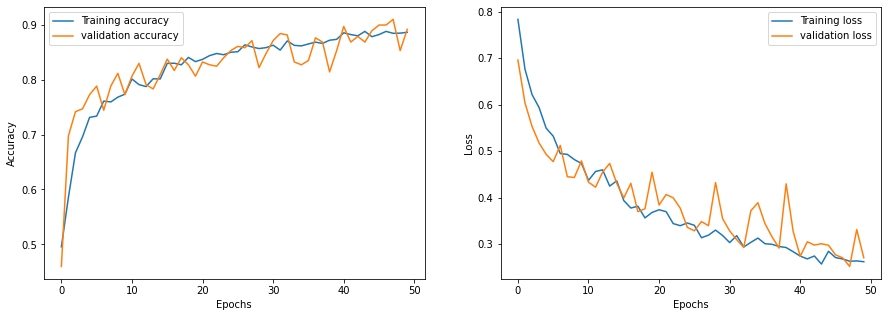

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(50),train_accu,label= 'Training accuracy')
plt.plot(range(50),val_accu,label = 'validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50),train_loss,label= 'Training loss')
plt.plot(range(50),val_loss,label = 'validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

actual label Male
predicted_label Male


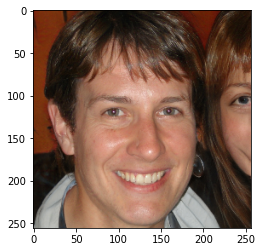

In [23]:
for image, label in df_test.take(1):
  plt.imshow(image[0].numpy().astype('int'))
  print('actual label', classes[label[0]])

  prediction = model.predict(image)
  print('predicted_label',classes[np.argmax(prediction[0])] )